# Overview
Use this notebook to convert an OCT image you have to a virtual H&E image for evaluation.

To get started,
[open this notebook in colab](https://colab.research.google.com/github/WinetraubLab/zero_shot_segmentation/blob/main/testing_sam.ipynb)
 and run.


# inputs

Assumptions:

oct scan x/z rates:
*   microns per pixel z = 1
*   microns per pixel x = 1

pix2pix input sizes:
*   virtual histology input width = 256
*   virtual histology input height = 256

pix2pix input x/z rates:
*   microns per pixel z = 1
*   microns per pixel x = 2

In [1]:
# Pre-processed dataset
preprocessed_dataset_path = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x OCT2Hist Model (Paper V2)/Results/TestSet/"

# Define input images
preprocessed_oct_image_paths = [
 (preprocessed_dataset_path + "LE-03-Slide04_Section01_yp0_patch01_real_A.png"), # Used in Paper Figure 3.b
 (preprocessed_dataset_path + "LG-19-Slide04_Section02_yp0_patch01_real_A.png"), # Used in Paper Figure 3.c
 (preprocessed_dataset_path + "LF-01-Slide04_Section02_yp0_patch01_real_A.png"), # Used in Paper Figure 3.d
 (preprocessed_dataset_path + "LG-44-Slide05_Section03_yp0_patch01_real_A.png"), # Used in Paper Figure 3.e
]
preprocessed_oct_image_paths = [s.replace("_real_A", "_fake_B") for s in preprocessed_oct_image_paths]
print(preprocessed_oct_image_paths)

['/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x OCT2Hist Model (Paper V2)/Results/TestSet/LE-03-Slide04_Section01_yp0_patch01_fake_B.png', '/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x OCT2Hist Model (Paper V2)/Results/TestSet/LG-19-Slide04_Section02_yp0_patch01_fake_B.png', '/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x OCT2Hist Model (Paper V2)/Results/TestSet/LF-01-Slide04_Section02_yp0_patch01_fake_B.png', '/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x OCT2Hist Model (Paper V2)/Results/TestSet/LG-44-Slide05_Section03_yp0_patch01_fake_B.png']


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
#segment anything (sam)
using_colab = True
visualize_sam_outputs = True


#sam model type and weights checkpoint
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

In [4]:
FIG_SIZE = (5,5)

In [5]:
#rf - roboflow dataset related params
rf_api_key="R04BinsZcBZ6PsfKR2fP"
rf_workspace="yolab-kmmfx"
rf_project = "connect_from_colab"
rf_dataset = "png-mask-semantic"

In [6]:
%pip install dataclasses-json
%pip install supervision
from IPython.display import clear_output
clear_output()

In [7]:
!git clone --recurse-submodules https://github.com/WinetraubLab/zero_shot_segmentation.git


Cloning into 'zero_shot_segmentation'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 150 (delta 61), reused 78 (delta 18), pack-reused 0
Receiving objects: 100% (150/150), 13.91 MiB | 23.42 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [8]:
!git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-ModelInference


Cloning into 'OCT2Hist-ModelInference'...
remote: Enumerating objects: 709, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 709 (delta 111), reused 149 (delta 81), pack-reused 504
Receiving objects: 100% (709/709), 24.82 MiB | 20.60 MiB/s, done.
Resolving deltas: 100% (368/368), done.
Submodule 'pytorch-CycleGAN-and-pix2pix' (https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) registered for path 'pytorch-CycleGAN-and-pix2pix'
Cloning into '/content/OCT2Hist-ModelInference/pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2513, done.        
remote: Total 2513 (delta 0), reused 0 (delta 0), pack-reused 2513        
Receiving objects: 100% (2513/2513), 8.20 MiB | 18.32 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
Submodule path 'pytorch-CycleGAN-and-pix2pix': checked out '9f8f61e5a375c2e01c5187d093ce9c2409f409b0'


In [9]:
!pip install torch
!pip install torchvision
import torch
import torchvision

In [10]:
%run /content/zero_shot_segmentation/setup_roboflow_and_sam.ipynb
from IPython.display import clear_output
clear_output()

In [11]:
sys.path.append('/content/zero_shot_segmentation')

from zero_shot_utils.utils import visualize_masks_on_img

#Zero shot pipeline

In [25]:
# Path to an OCT image to convert
oct_input_image_path = preprocessed_oct_image_paths[0]

#run sam on virtual histology

To generate masks, just run `generate` on an image.

In [48]:
import cv2

input = cv2.imread(oct_input_image_path)
input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)


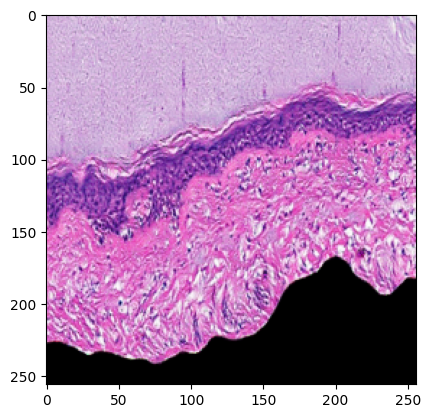

In [49]:
sys.path.append('/content/OCT2Hist-ModelInference')
from utils.show_images import showImg
showImg(input)

In [53]:
#see doc here: https://github.com/facebookresearch/segment-anything/blob/6fdee8f2727f4506cfbbe553e23b895e27956588/segment_anything/automatic_mask_generator.py#L65

#sam algorithm input parameters
points_per_side = 32 #relevant
points_per_batch = 64
pred_iou_thresh = 0.88 #relevant
stability_score_thresh= 0.95 #relevant
stability_score_offset = 1.0 #relevant
box_nms_thresh= 0.7 #relevant
crop_n_layers = 0 #relevant
crop_nms_thresh= 0.7 #relevant
crop_overlap_ratio = 512 / 1500 #relevant
crop_n_points_downscale_factor = 1 #relevant
point_grids = None
min_mask_region_area = 0 #relevant

In [54]:
#create the mask generator with the selected params
mask_generator = SamAutomaticMaskGenerator(sam, points_per_side,
points_per_batch,
pred_iou_thresh,
stability_score_thresh,
stability_score_offset,
box_nms_thresh,
crop_n_layers,
crop_nms_thresh,
crop_overlap_ratio,
crop_n_points_downscale_factor,
point_grids,
min_mask_region_area)

In [55]:
masks = mask_generator.generate(input)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

Show all the masks overlayed on the image.

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:[link text](https://)


#project on oct

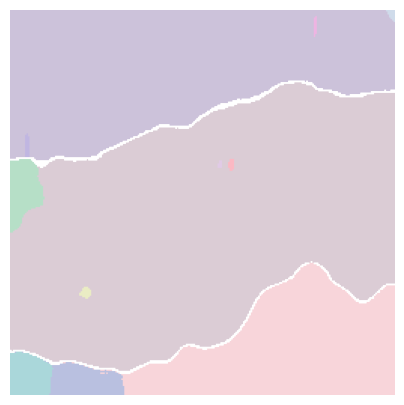

In [56]:
import numpy as np
white_image = np.ones_like(input) * 255
visualize_masks_on_img(white_image, masks, FIG_SIZE)

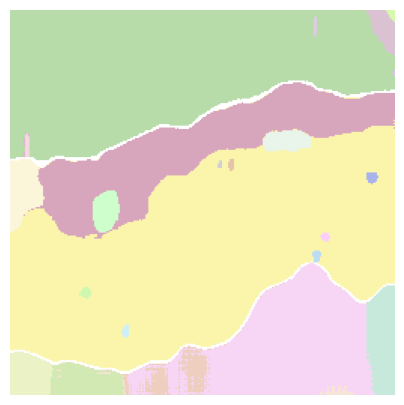

In [58]:
#generate with a low threshold:
mask_generator.stability_score_thresh=0.0
masks2 = mask_generator.generate(input)
visualize_masks_on_img(white_image, masks2, FIG_SIZE)

In [42]:
sorted_masks = sorted(masks2, key=(lambda x: x['area']), reverse=True)

In [43]:
def show_anns_for_single_mask(ann):
  ax = plt.gca()
  ax.set_autoscale_on(False)
  img = np.ones((ann['segmentation'].shape[0], ann['segmentation'].shape[1], 4))
  img[:,:,3] = 0
  m = ann['segmentation']
  color_mask = np.concatenate([np.random.random(3), [0.35]])
  img[m] = color_mask
  ax.imshow(img)

x,y,w,h:(0, 6, 255, 234)
predicted_iou:1.0084675550460815
stability_score:0.8419346213340759
point_coords:[[4.0, 196.0]]


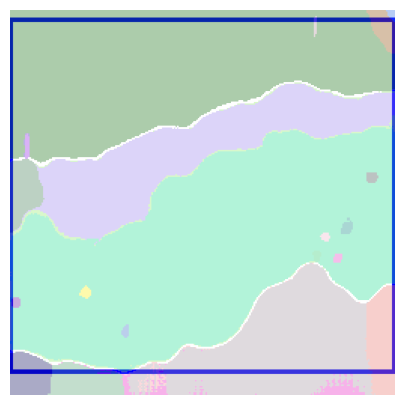

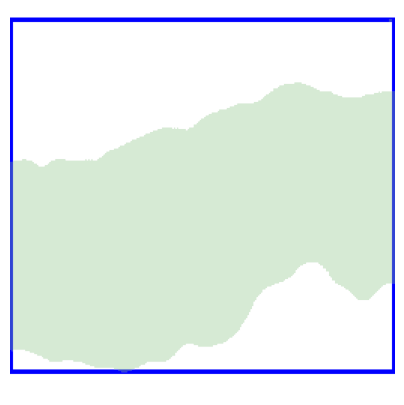

x,y,w,h:(0, 77, 255, 162)
predicted_iou:0.9844453930854797
stability_score:0.9210795760154724
point_coords:[[148.0, 108.0]]


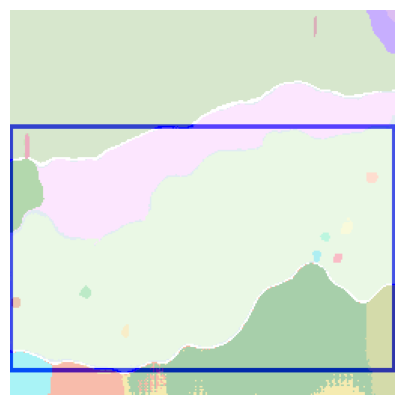

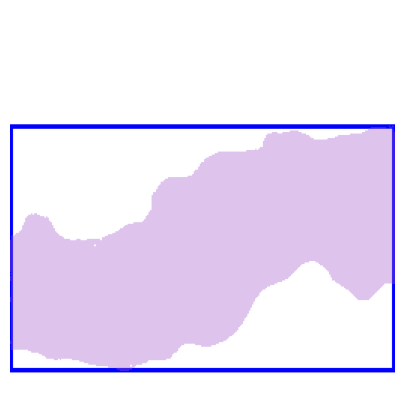

x,y,w,h:(0, 0, 255, 101)
predicted_iou:1.025307536125183
stability_score:0.9885677695274353
point_coords:[[204.0, 4.0]]


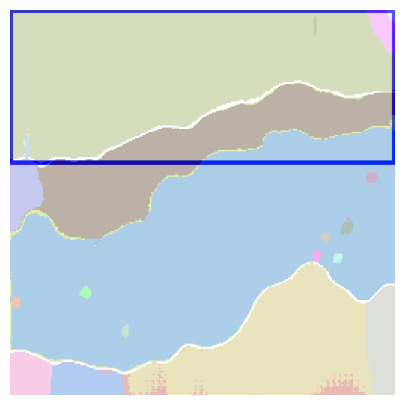

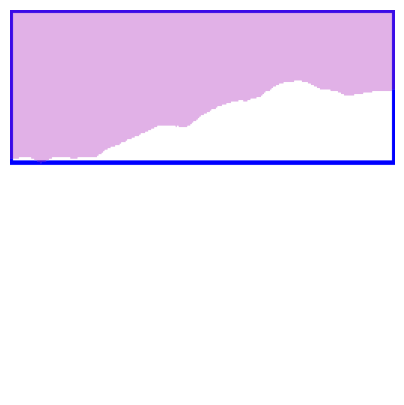

x,y,w,h:(0, 168, 255, 87)
predicted_iou:1.0071974992752075
stability_score:0.9887265563011169
point_coords:[[196.0, 244.0]]


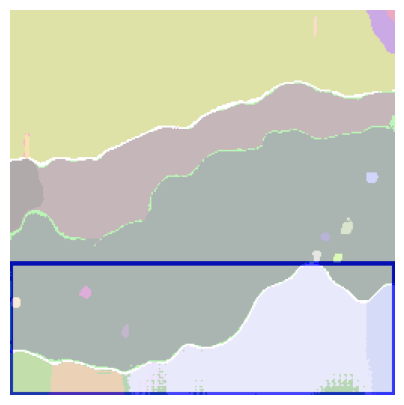

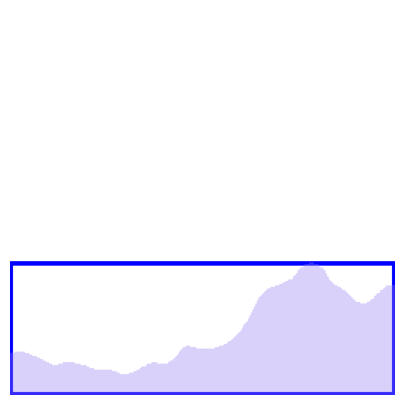

x,y,w,h:(77, 168, 178, 87)
predicted_iou:0.9396194219589233
stability_score:0.7697395086288452
point_coords:[[108.0, 244.0]]


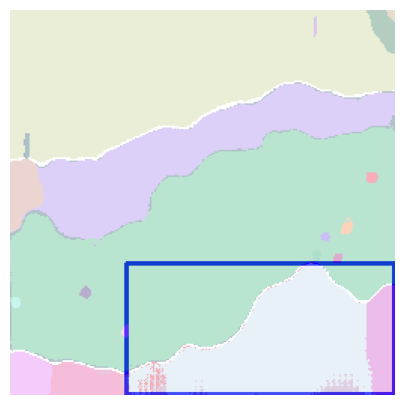

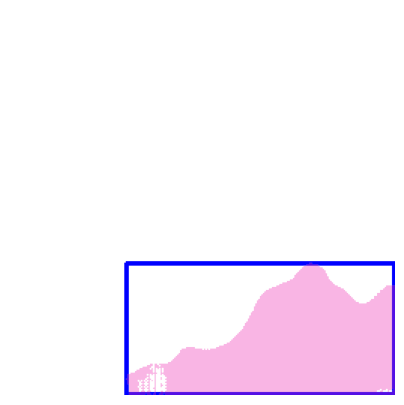

x,y,w,h:(0, 49, 255, 106)
predicted_iou:0.9534316658973694
stability_score:0.9345602989196777
point_coords:[[156.0, 68.0]]


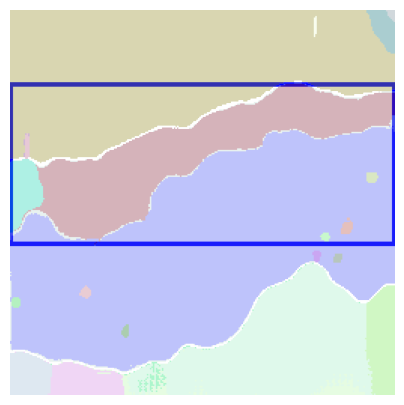

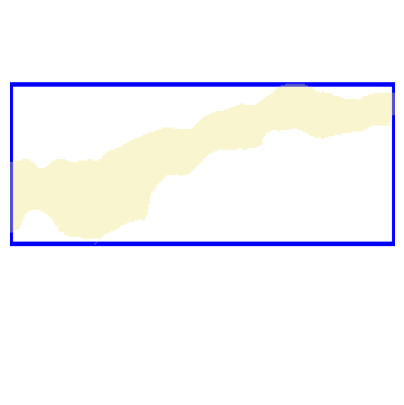

x,y,w,h:(0, 226, 235, 29)
predicted_iou:0.9671850204467773
stability_score:0.4394771158695221
point_coords:[[52.0, 244.0]]


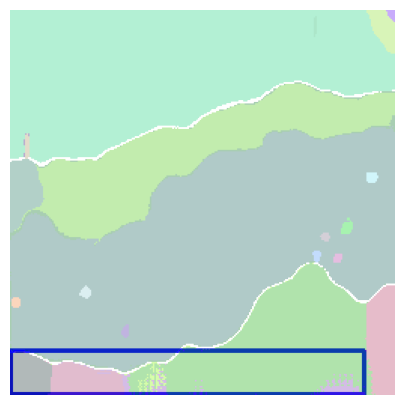

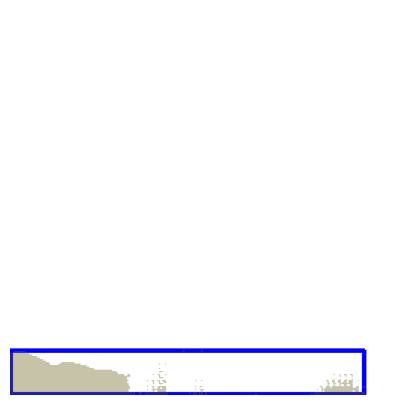

x,y,w,h:(0, 227, 75, 28)
predicted_iou:0.9335240125656128
stability_score:0.9195122122764587
point_coords:[[4.0, 244.0]]


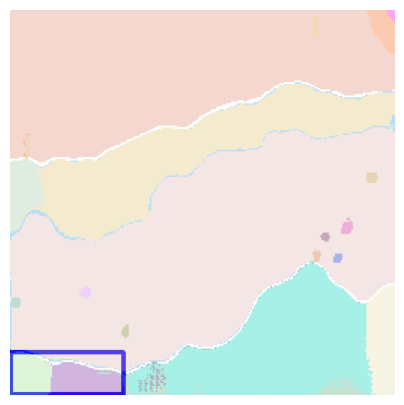

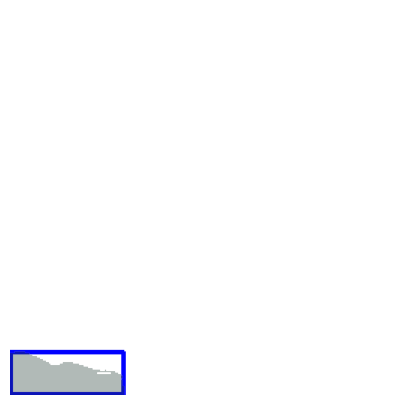

x,y,w,h:(236, 183, 19, 72)
predicted_iou:0.9012653231620789
stability_score:0.8868640661239624
point_coords:[[244.0, 228.0]]


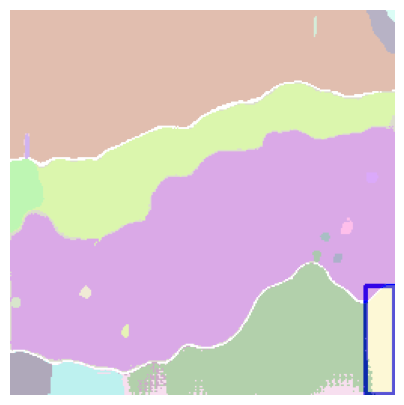

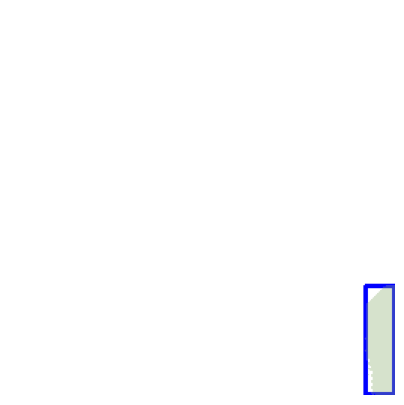

x,y,w,h:(0, 99, 22, 48)
predicted_iou:0.9419638514518738
stability_score:0.9655612111091614
point_coords:[[12.0, 132.0]]


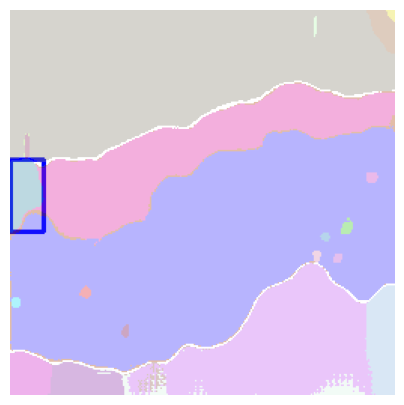

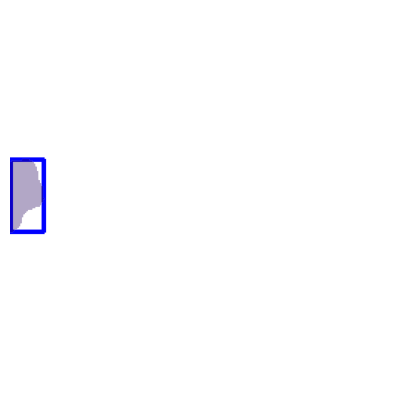

In [44]:
for i_mask in range(10):
  x,y,w,h = sorted_masks[i_mask]['bbox']
  print(f"x,y,w,h:{x,y,w,h}")
  predicted_iou = sorted_masks[i_mask]['predicted_iou']
  print(f"predicted_iou:{predicted_iou}")
  stability_score = sorted_masks[i_mask]['stability_score']
  print(f"stability_score:{stability_score}")
  point_coords = sorted_masks[i_mask]['point_coords']
  print(f"point_coords:{point_coords}")
  import matplotlib.pyplot as plt
  color = (0, 0, 255)  # Red color in BGR format
  thickness = 2  # You can adjust the thickness
  image_with_rectangle = cv2.rectangle(white_image.copy(), (x, y), (x + w, y + h), color, thickness)
  visualize_masks_on_img(image_with_rectangle, masks2, FIG_SIZE)


  plt.figure(figsize=FIG_SIZE)
  plt.imshow(image_with_rectangle)
  show_anns_for_single_mask(sorted_masks[i_mask])
  plt.axis('off')
  plt.show()
